In [1]:
import pandas as pd
import numpy as np
import pandahouse 
from scipy import stats
import seaborn as sns

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250520',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
q = '''
SELECT exp_group, 
       user_id,
       sum(action = 'like') as like,
       sum(action = 'view') as view,
       like/view as ctr
FROM {db}.feed_actions
WHERE exp_group in (1,2) and toDate(time) between '2025-05-02' and '2025-05-08'
GROUP BY exp_group, user_id
'''

In [4]:
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,like,view,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750


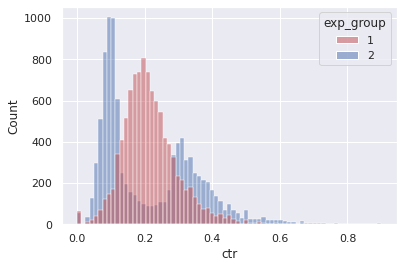

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

### t-тест

In [8]:
# t-test
stats.ttest_ind(df[df.exp_group==1].ctr,
                df[df.exp_group==2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

### тест Манна-Уитни

In [6]:
# Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 1].ctr)

MannwhitneyuResult(statistic=43777627.0, pvalue=4.632205841806026e-45)

### t-тест со сглаживанием

In [7]:
# t-test со сглаживанием
# функция сглаживания
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

# рассчитываем глобальный CTR по группам
global_ctr_1 = df[df.exp_group==1].like.sum()/df[df.exp_group==1].view.sum()
global_ctr_2 = df[df.exp_group==2].like.sum()/df[df.exp_group==2].view.sum()

# параметр сглаживания
alpha = 5  


df['smoothed_ctr'] = np.where(
    df['exp_group'] == 1,
    get_smothed_ctr(df['like'], df['view'], global_ctr_1, alpha),
    get_smothed_ctr(df['like'], df['view'], global_ctr_2, alpha)
)

# t-test
stats.ttest_ind(df[df.exp_group==1].smoothed_ctr,
                df[df.exp_group==2].smoothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

### Пуассоновский бутстреп

<Axes: ylabel='Count'>

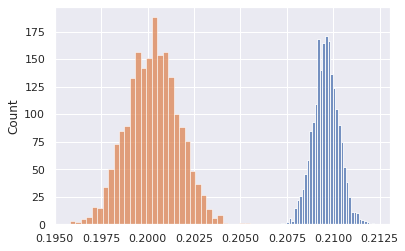

In [10]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].like.to_numpy()
views1 = df[df.exp_group == 1].view.to_numpy()
likes2 = df[df.exp_group == 2].like.to_numpy()
views2 = df[df.exp_group == 2].view.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

### Бакетное преобразование

In [13]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2025-05-02' and '2025-05-08'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [14]:
# t-test
stats.ttest_ind(df[df.exp_group==1].bucket_ctr,
                df[df.exp_group==2].bucket_ctr,
                equal_var=False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

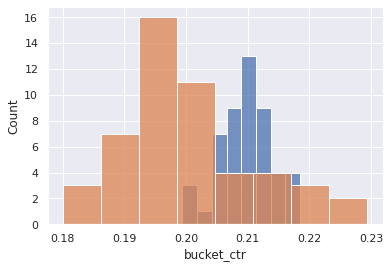

In [15]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)
sns.histplot(df[df.exp_group == 2].bucket_ctr)

### Выводы

1. Все тесты, за исключением t-теста на индивидуальных CTR, показывают наличие статестически значимого различия. Возможная причина - ненормальность распределения exp_goup = 2. Тесты поверх Пуасоновского бутстрепа и бакетного преобразования показали меньшую чувствительность к распределению генеральной совокупности. 
2. Новая рекомендательная система "разбила" пользователей на две подгруппы: в одной CTR упал, в другой - вырос. 
3. Оценка общегруппового CTR показывает статестически значимое изменение - новая рекомендательная система дала эффект и он отрицательный. 